In [2]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import pandas as pd
from matplotlib import pyplot as plt
import sklearn
from sklearn.decomposition import PCA
import numpy as np
import datetime
import os

from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.python.framework.ops import enable_eager_execution
from models.vae import DenseVariationalAutoencoder, VariationalAutoencoder
#disable_eager_execution()

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

TRAINING_FRACTION = 0.8
N_DENSE = 2
L=16
NON_LINEAR_ACTIVATION_BOOL=True

In [3]:
# run params
SECTION = 'vae'
RUN_ID = '0003'
#DATA_NAME = 'digits'
DATA_NAME = 'xy'
RUN_FOLDER = '{}/run/{}/'.format(os.getcwd(), SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #

In [4]:
user = 1
if user == 1:
    prefix_s3 = "/home/owen/"
    prefix_data = "/home/owen/repos/"
elif user == 2:
    prefix_data = "/Users/omyers/repos/"
    
tensorboard_log_dir = "{}/logs/fit/".format(prefix_s3) + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


In [5]:
# Just do this so it is easier to configure arbitrary choices
work_with_t_list = [ "00.10", "00.20", "00.30", "00.40", "00.50", "00.60", "00.70", "00.80", "00.90", "01.00", "01.10", "01.20", "01.30", "01.40", "01.50", "01.60", "01.70", "01.80", "01.90", "02.00"]

In [6]:
df_bins = None
df_conf = None
for i, t_string in enumerate(work_with_t_list):
    bins_f_name = "{prefix_data}z3support/data/XYMLData/2DXY-configs-L-{l}/bins_2DXY-configs-L-{l}-{l}-{t}-0000.txt".format(
        l = str(L).zfill(4),
        t = t_string,
        prefix_data = prefix_data
    )
    configs_f_name = "{prefix_data}z3support/data/XYMLData/2DXY-configs-L-{l}/spinConfigs_2DXY-configs-L-{l}-{l}-{t}-0000.txt".format(
        l = str(L).zfill(4),
        t = t_string,
        prefix_data = prefix_data
    )
    if i == 0:
        df_bins = pd.read_csv(bins_f_name, sep="\t")
        df_conf = pd.read_csv(configs_f_name, delimiter=r"\s+", header=None)
    else:
        cur_df_bins = pd.read_csv(bins_f_name, sep="\t")
        cur_df_conf = pd.read_csv(configs_f_name, delimiter=r"\s+", header=None)
        df_bins = df_bins.append(cur_df_bins) 
        df_conf = df_conf.append(cur_df_conf) 
    print(bins_f_name)

/home/owen/repos/z3support/data/XYMLData/2DXY-configs-L-0016/bins_2DXY-configs-L-0016-0016-00.10-0000.txt
/home/owen/repos/z3support/data/XYMLData/2DXY-configs-L-0016/bins_2DXY-configs-L-0016-0016-00.20-0000.txt
/home/owen/repos/z3support/data/XYMLData/2DXY-configs-L-0016/bins_2DXY-configs-L-0016-0016-00.30-0000.txt
/home/owen/repos/z3support/data/XYMLData/2DXY-configs-L-0016/bins_2DXY-configs-L-0016-0016-00.40-0000.txt
/home/owen/repos/z3support/data/XYMLData/2DXY-configs-L-0016/bins_2DXY-configs-L-0016-0016-00.50-0000.txt
/home/owen/repos/z3support/data/XYMLData/2DXY-configs-L-0016/bins_2DXY-configs-L-0016-0016-00.60-0000.txt
/home/owen/repos/z3support/data/XYMLData/2DXY-configs-L-0016/bins_2DXY-configs-L-0016-0016-00.70-0000.txt
/home/owen/repos/z3support/data/XYMLData/2DXY-configs-L-0016/bins_2DXY-configs-L-0016-0016-00.80-0000.txt
/home/owen/repos/z3support/data/XYMLData/2DXY-configs-L-0016/bins_2DXY-configs-L-0016-0016-00.90-0000.txt
/home/owen/repos/z3support/data/XYMLData/2DXY-

In [7]:
df_bins.shape

(200000, 10)

In [8]:
df_bins = df_bins.astype(
    {
        " T ": float,
        " binNum": int,
    }
)

In [9]:
df_conf["T"] = df_bins[" T "]

In [10]:
mean_col = df_conf[0].copy()
for i in range(1, L):
    mean_col += df_conf[i]

mean_col /= L

In [11]:
df_conf["M"] = mean_col

In [12]:
df_conf.columns

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       248, 249, 250, 251, 252, 253, 254, 255, 'T', 'M'],
      dtype='object', length=258)

In [13]:
df_conf.shape

(200000, 258)

In [14]:
df_conf.head()

,0,1,2,3,4,5,6,7,8,9,...,248,249,250,251,252,253,254,255,T,M
0,1.556908,1.700251,1.286740,1.333554,1.935889,1.392411,1.903922,1.781047,1.644003,1.456510,...,1.724801,1.794323,2.160901,2.016668,1.862466,2.099976,1.755041,2.080891,0.1,1.676787
1,0.449358,0.284169,0.110582,0.316963,0.309245,0.007220,0.132248,0.248091,6.199557,6.210290,...,0.113690,0.187911,0.381211,0.439792,0.533806,0.380159,6.243337,0.342518,0.1,0.998589
2,5.874689,5.861319,5.717695,5.349464,5.149222,5.051441,5.754105,5.572867,5.614452,5.757395,...,5.947179,5.673022,5.783555,5.720445,5.787259,5.683092,5.809804,5.735588,0.1,5.631094
3,0.579087,0.398948,0.059830,0.212079,0.207130,0.406396,0.264235,0.255291,0.622365,0.351162,...,0.847066,0.497288,0.783738,0.665467,0.731709,0.514824,0.226228,0.894068,0.1,0.421956
4,3.180521,3.118362,3.202986,3.077825,2.982245,3.182920,2.962104,2.911524,2.588305,2.857718,...,2.919455,3.058893,3.098180,2.882240,2.939362,3.138479,3.188607,3.699828,0.1,3.030602


In [15]:
cols = []
for i in range(L*L):
    cols.append(str(i))
    cols.append(str(i))
print(cols)

['0', '0', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9', '10', '10', '11', '11', '12', '12', '13', '13', '14', '14', '15', '15', '16', '16', '17', '17', '18', '18', '19', '19', '20', '20', '21', '21', '22', '22', '23', '23', '24', '24', '25', '25', '26', '26', '27', '27', '28', '28', '29', '29', '30', '30', '31', '31', '32', '32', '33', '33', '34', '34', '35', '35', '36', '36', '37', '37', '38', '38', '39', '39', '40', '40', '41', '41', '42', '42', '43', '43', '44', '44', '45', '45', '46', '46', '47', '47', '48', '48', '49', '49', '50', '50', '51', '51', '52', '52', '53', '53', '54', '54', '55', '55', '56', '56', '57', '57', '58', '58', '59', '59', '60', '60', '61', '61', '62', '62', '63', '63', '64', '64', '65', '65', '66', '66', '67', '67', '68', '68', '69', '69', '70', '70', '71', '71', '72', '72', '73', '73', '74', '74', '75', '75', '76', '76', '77', '77', '78', '78', '79', '79', '80', '80', '81', '81', '82', '82', '83', '83', '84', '84',

In [16]:
xy_spec = ["x", "y"] * L*L

In [17]:
for i in zip(cols, xy_spec):
    continue
    #print(i)

In [18]:
np_angle_matrix = df_conf.drop(["T","M"], axis=1).to_numpy()

In [19]:
np_x_matrix = np.cos(np_angle_matrix)
np_y_matrix = np.sin(np_angle_matrix)

In [20]:
#np.concatenate(np_x_matrix, np_x_matrix, axis=1)
df = pd.DataFrame(columns=pd.MultiIndex.from_tuples(zip(cols, xy_spec)))

In [21]:
df.sort_index(ascending=True, inplace=True, axis=1)

In [22]:
df.loc[:, (slice(None), slice("x"))] = np_x_matrix

In [23]:
np_x_matrix

array([[ 0.01388745, -0.12909381,  0.28025149, ..., -0.50482557,
        -0.18320417, -0.48826   ],
       [ 0.90072595,  0.95989501,  0.99389209, ...,  0.92860548,
         0.99920618,  0.94191198],
       [ 0.91771916,  0.91232647,  0.8443258 , ...,  0.82528289,
         0.89003206,  0.85377805],
       ...,
       [ 0.35518189,  0.86364036,  0.5413335 , ...,  0.82841878,
         0.73347829,  0.91677531],
       [-0.83796256, -0.91055089, -0.24791174, ...,  0.99678711,
         0.3697388 ,  0.26907025],
       [ 0.96818999, -0.76737471,  0.06265026, ..., -0.928166  ,
        -0.99514568,  0.3016261 ]])

In [24]:
np_y_matrix

array([[ 0.99990356,  0.99163239,  0.95992661, ...,  0.86322138,
         0.98307489,  0.87269822],
       [ 0.4343878 ,  0.28035972,  0.11035628, ...,  0.37106854,
        -0.03983736,  0.33585982],
       [-0.39722985, -0.40946358, -0.53583014, ..., -0.56471953,
        -0.45589795, -0.52063715],
       ...,
       [ 0.93479721,  0.50410845,  0.84080797, ..., -0.56010921,
         0.67971288,  0.39940334],
       [-0.54572773,  0.413397  , -0.96878262, ...,  0.0800965 ,
        -0.92913574, -0.96312055],
       [-0.25021621,  0.64119892,  0.99803554, ..., -0.37216647,
         0.09841277, -0.95342629]])

In [25]:
df.loc[:, (slice(None), "y")] = np_y_matrix

In [25]:
df

0                   1                  10                 100  \
               x         y         x         y         x         y         x   
0       0.013887  0.999904 -0.129094  0.991632  0.280251  0.959927  0.235024   
1       0.900726  0.434388  0.959895  0.280360  0.993892  0.110356  0.950186   
2       0.917719 -0.397230  0.912326 -0.409464  0.844326 -0.535830  0.594847   
3       0.836963  0.547260  0.921470  0.388449  0.998211  0.059795  0.977595   
4      -0.999242 -0.038918 -0.999730  0.023228 -0.998116 -0.061355 -0.997968   
...          ...       ...       ...       ...       ...       ...       ...   
199995  0.972849 -0.231441  0.094902  0.995487  0.995847  0.091043  0.866387   
199996  0.767148 -0.641470  0.935878  0.352324  0.734895  0.678181  0.112359   
199997  0.355182  0.934797  0.863640  0.504108  0.541334  0.840808 -0.274097   
199998 -0.837963 -0.545728 -0.910551  0.413397 -0.247912 -0.968783 -0.219128   
199999  0.968190 -0.250216 -0.767375  0.641199  0.062650  0.998036  0.963963   

                       101            ...        95                  96  \
               y         x         y  ...         x         y         x   
0       0.971990 -0.357036  0.934091  ... -0.431244  0.902235 -0.287552   
1       0.311682  0.952564  0.304340  ...  0.904840  0.425751  0.860877   
2      -0.803839  0.423072 -0.906096  ...  0.845796 -0.533506  0.879528   
3       0.210493  0.978625  0.205652  ...  0.786629  0.617426  0.744034   
4       0.063724 -0.987331  0.158675  ... -0.966556  0.256455 -0.979621   
...          ...       ...       ...  ...       ...       ...       ...   
199995 -0.499374  0.895477 -0.445107  ...  0.163646  0.986519  0.820065   
199996 -0.993668  0.164847  0.986319  ... -0.791902  0.610649 -0.706129   
199997 -0.961702 -0.473178 -0.880967  ...  0.532440 -0.846468  0.981438   
199998 -0.975696 -0.672153 -0.740412  ...  0.991617 -0.129213  0.570984   
199999 -0.266036  0.712408 -0.701765  ... -0.996632 -0.082003  0.876971   

                        97                  98                  99            
               y         x         y         x         y         x         y  
0       0.957765 -0.504826  0.863221 -0.183204  0.983075 -0.488260  0.872698  
1       0.508813  0.928605  0.371069  0.999206 -0.039837  0.941912  0.335860  
2      -0.475846  0.825283 -0.564720  0.890032 -0.455898  0.853778 -0.520637  
3       0.668142  0.870379  0.492381  0.974519  0.224304  0.626246  0.779625  
4       0.200855 -0.999995  0.003113 -0.998895 -0.046997 -0.848191 -0.529690  
...          ...       ...       ...       ...       ...       ...       ...  
199995  0.572270 -0.148309 -0.988941 -0.244211  0.969722 -0.786918 -0.617057  
199996 -0.708083 -0.961756  0.273906 -0.986207  0.165514 -0.932619  0.360862  
199997 -0.191778  0.828419 -0.560109  0.733478  0.679713  0.916775  0.399403  
199998 -0.820961  0.996787  0.080096  0.369739 -0.929136  0.269070 -0.963121  
199999 -0.480544 -0.928166 -0.372166 -0.995146  0.098413  0.301626 -0.953426  

[200000 rows x 512 columns]

In [27]:
train_with_meta_info = df.sample(frac=TRAINING_FRACTION, axis=0)
test_with_meta_info = df.drop(index=train_with_meta_info.index)
#train = train_with_meta_info.drop(["T","M"], axis=1)
#test = test_with_meta_info.drop(["T","M"], axis=1)
train = train_with_meta_info
test = test_with_meta_info

In [27]:
img_pca = PCA(n_components=N_DENSE)
img_pca.fit(train.to_numpy())

PCA(n_components=2)

In [28]:
components = img_pca.transform(df.to_numpy())

In [29]:
df.to_numpy().shape

(200000, 512)

In [30]:
components.shape

(200000, 2)

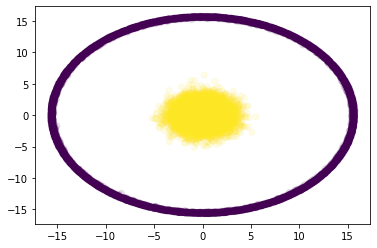

In [36]:
if N_DENSE > 1:
    plt.scatter(components[:,0], components[:,1], c=pd.to_numeric(df_conf["T"]), alpha=0.1)

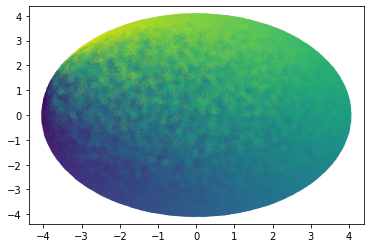

In [32]:
if N_DENSE > 1:
    plt.scatter(components[:,0], components[:,1], c=pd.to_numeric(df_conf["M"]), alpha=0.1)

# Dense AE

In [33]:
simp_ae = tf.keras.Sequential(
    [
        keras.layers.InputLayer(input_shape=(L*L*2,)),
        keras.layers.Dense(N_DENSE, use_bias=False, name='latent_space'),
        keras.layers.Dense(L*L*2),
    ]
)

print(simp_ae.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 latent_space (Dense)        (None, 2)                 64        
                                                                 
 dense (Dense)               (None, 32)                96        
                                                                 
Total params: 160
Trainable params: 160
Non-trainable params: 0
_________________________________________________________________
None


2022-08-30 22:39:28.291916: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-30 22:39:28.291938: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: owen-PRIME-Z390-A
2022-08-30 22:39:28.291942: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: owen-PRIME-Z390-A
2022-08-30 22:39:28.291993: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.141.3
2022-08-30 22:39:28.292009: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.141.3
2022-08-30 22:39:28.292013: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.141.3
2022-08-30 22:39:28.292340: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following

In [34]:
tb_callback = keras.callbacks.TensorBoard(
    log_dir=tensorboard_log_dir,
    histogram_freq=0,  
    write_graph=True,
    write_images=True
)

simp_ae.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [35]:
simp_ae.fit(
    batch_size=16,
    x=train.to_numpy(),
    y=train.to_numpy(),
    epochs=20,
    callbacks=[tb_callback]
)

Epoch 1/20
10000/10000 [==============================] - 10s 934us/step - loss: 0.2000 - mae: 0.3347
Epoch 2/20
10000/10000 [==============================] - 9s 941us/step - loss: 0.1910 - mae: 0.3257
Epoch 3/20
10000/10000 [==============================] - 9s 922us/step - loss: 0.1910 - mae: 0.3257
Epoch 4/20
10000/10000 [==============================] - 8s 824us/step - loss: 0.1910 - mae: 0.3257
Epoch 5/20
10000/10000 [==============================] - 10s 1ms/step - loss: 0.1910 - mae: 0.3256
Epoch 6/20
10000/10000 [==============================] - 10s 1000us/step - loss: 0.1910 - mae: 0.3256
Epoch 7/20
10000/10000 [==============================] - 10s 1ms/step - loss: 0.1910 - mae: 0.3256
Epoch 8/20
10000/10000 [==============================] - 10s 972us/step - loss: 0.1910 - mae: 0.3256
Epoch 9/20
10000/10000 [==============================] - 10s 999us/step - loss: 0.1910 - mae: 0.3256
Epoch 10/20
10000/10000 [==============================] - 10s 973us/step - loss: 0.1910

In [36]:
mid_layer = simp_ae.get_layer('latent_space')

In [37]:
mid_layer.get_weights()[0].shape

(32, 2)

In [38]:
extractor = keras.Model(inputs=simp_ae.inputs,
                        outputs=[layer.output for layer in simp_ae.layers])

In [39]:
features = extractor(df.to_numpy())

In [40]:
features[0]

<tf.Tensor: shape=(200000, 2), dtype=float32, numpy=
array([[-1.3602887 , -0.29000616],
       [-0.12695111, -1.4134393 ],
       [ 1.1141955 ,  0.85279393],
       ...,
       [-0.58732355,  0.1996884 ],
       [-0.06488425,  0.6769451 ],
       [ 0.31997064,  0.16234165]], dtype=float32)>

In [41]:
features[0][:,0]

<tf.Tensor: shape=(200000,), dtype=float32, numpy=
array([-1.3602887 , -0.12695111,  1.1141955 , ..., -0.58732355,
       -0.06488425,  0.31997064], dtype=float32)>

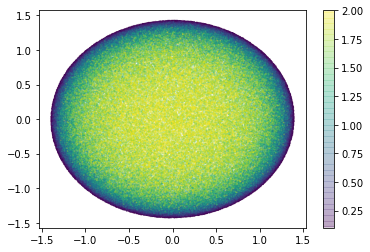

In [42]:
plt.scatter(features[0][:,0], features[0][:,1], c=df_conf["T"], s=0.5, alpha=0.2)
plt.colorbar()

# Dense VAE

In [45]:
x = train.to_numpy().reshape(-1,L*L*2)
x_test = test.to_numpy().reshape(-1,L*L*2)
x = x.astype(float)
x_test = x_test.astype(float)

In [46]:
print(x.shape)
print(x_test.shape)

(16000, 512)
(4000, 512)


In [47]:
print(type(x))
print(type(x_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [48]:
#x = x+10
#x_test = x_test+10

In [39]:
# Need to do this for VAE but cant have it on for the feature and scatter stuff for the normal AE above
disable_eager_execution()
vae = DenseVariationalAutoencoder(
    input_dim=(L*L*2,),
    encoder_layer_sizes=[L, 2],
    decoder_layer_sizes=[2, L, L*L*2],
    z_dim=N_DENSE,
    non_linear_activation_bool=NON_LINEAR_ACTIVATION_BOOL
)

In [50]:
LEARNING_RATE = 0.0005
#R_LOSS_FACTOR = 1000
R_LOSS_FACTOR = 1000

In [51]:
vae.compile(LEARNING_RATE, R_LOSS_FACTOR)

In [52]:
BATCH_SIZE = 16
EPOCHS = 10
PRINT_EVERY_N_BATCHES = 10
INITIAL_EPOCH = 0

In [53]:
#x.shape
#vae.encoder.summary()
vae.decoder.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 6         
                                                                 
 dense_4 (Dense)             (None, 2)                 6         
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 2)                 0         
                                                                 
 dense_5 (Dense)             (None, 16)                48        
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 16)                0         
                                                                 
 dense_6 (Dense)             (None, 512)               8704

In [54]:
r = vae.train(     
    x,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    run_folder = RUN_FOLDER,
    print_every_n_batches = PRINT_EVERY_N_BATCHES,
    initial_epoch = INITIAL_EPOCH,
    #x_test=tf.data.Dataset.from_tensor_slices(x_test)
)

Train on 8000 samples, validate on 8000 samples
Epoch 1/10
  16/8000 [..............................] - ETA: 37s - loss: 994.6033 - vae_r_loss: 994.0046 - vae_kl_loss: 0.5987

2022-09-09 13:55:43.139837: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-09-09 13:55:43.295828: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-09-09 13:55:43.295846: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-09-09 13:55:43.299270: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-09-09 13:55:43.300096: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-09-09 13:55:43.301277: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /home/owen/logs/fit/20220909-135542/plugins/profile/2022_09_09_13_55_43

2022-09-09 13:55:43.301758: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /home/owen/logs/fit/20220909-135542/plugins/profile/2022_09_09_13_55_43/owen-PRIME-Z390-A.trace.json.

7344/8000 [==========================>...] - ETA: 0s - loss: 544.6124 - vae_r_loss: 534.4377 - vae_kl_loss: 10.1746

/home/owen/repos/z3support/pythonenv/lib/python3.8/site-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


8000/8000 [==============================] - 1s 88us/sample - loss: 537.5957 - vae_r_loss: 527.6219 - vae_kl_loss: 9.9739 - val_loss: 462.8436 - val_vae_r_loss: 455.7368 - val_vae_kl_loss: 7.1067
Epoch 2/10
8000/8000 [==============================] - 1s 86us/sample - loss: 450.9271 - vae_r_loss: 445.2224 - vae_kl_loss: 5.7046 - val_loss: 449.4474 - val_vae_r_loss: 444.9636 - val_vae_kl_loss: 4.4839
Epoch 3/10
8000/8000 [==============================] - 1s 79us/sample - loss: 439.3959 - vae_r_loss: 433.9167 - vae_kl_loss: 5.4792 - val_loss: 425.3127 - val_vae_r_loss: 417.7553 - val_vae_kl_loss: 7.5572
Epoch 4/10
8000/8000 [==============================] - 1s 87us/sample - loss: 414.6433 - vae_r_loss: 407.3091 - vae_kl_loss: 7.3341 - val_loss: 405.1985 - val_vae_r_loss: 397.2280 - val_vae_kl_loss: 7.9705
Epoch 5/10
8000/8000 [==============================] - 1s 93us/sample - loss: 393.5974 - vae_r_loss: 386.7689 - vae_kl_loss: 6.8285 - val_loss: 393.0034 - val_vae_r_loss: 387.4465 - 

/home/owen/repos/z3support/pythonenv/lib/python3.8/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


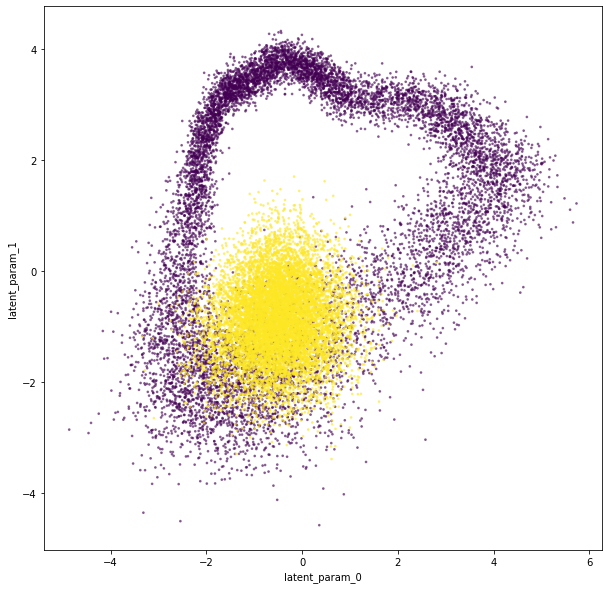

In [55]:
figsize = 10

z_points = vae.encoder.predict(df.to_numpy())

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize=(figsize, figsize))
#plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)
plt.scatter(z_points[:, 0] , z_points[:, 1], c=df_conf['T'], alpha=0.5, s=3)
plt.xlabel("latent_param_0")
plt.ylabel("latent_param_1")
plt.show()



# Convolutional VAE

In [31]:
train

0                   1                  10                 100  \
               x         y         x         y         x         y         x   
76526   0.214749  0.976669  0.610913  0.791698  0.593882  0.804552  0.672161   
111874 -0.288834  0.957379 -0.950745  0.309975  0.179967 -0.983673 -0.995406   
101528  0.080387 -0.996764  0.067928 -0.997690 -0.878662 -0.477445 -0.303741   
7388    0.550780 -0.834650  0.466356 -0.884597  0.614021 -0.789290  0.300106   
74539  -0.793721  0.608282 -0.233746  0.972298  0.073935  0.997263 -0.746762   
...          ...       ...       ...       ...       ...       ...       ...   
26376   0.509737 -0.860330  0.345796 -0.938310  0.591600 -0.806231  0.130402   
63838  -0.956436  0.291941 -0.436311  0.899796 -0.914609  0.404339  0.233178   
186466 -0.012774  0.999918 -0.367458  0.930040  0.994088 -0.108582  0.884771   
172254 -0.429206  0.903206  0.287170  0.957880  0.188857  0.982005 -0.925987   
91689  -0.412864 -0.910793  0.404523 -0.914528  0.218034 -0.975941 -0.322182   

                       101            ...        95                  96  \
               y         x         y  ...         x         y         x   
76526   0.740405 -0.144296  0.989535  ...  0.539674  0.841874 -0.490168   
111874 -0.095743 -0.264349  0.964427  ...  0.822638  0.568565  0.077142   
101528 -0.952755 -0.979644 -0.200743  ... -0.377043  0.926196  0.496986   
7388   -0.953906  0.293966 -0.955816  ...  0.301381 -0.953504  0.279322   
74539   0.665091 -0.796293  0.604910  ...  0.103620  0.994617  0.204782   
...          ...       ...       ...  ...       ...       ...       ...   
26376  -0.991461  0.403234 -0.915097  ...  0.616040 -0.787715  0.623073   
63838   0.972434  0.059861  0.998207  ...  0.205201  0.978720 -0.728065   
186466  0.466027  0.993133 -0.116990  ... -0.792396  0.610006  0.601213   
172254  0.377556 -0.053082  0.998590  ... -0.998776  0.049462 -0.528221   
91689  -0.946678 -0.697423 -0.716660  ...  0.062569 -0.998041  0.106414   

                        97                  98                  99            
               y         x         y         x         y         x         y  
76526   0.871628 -0.994713  0.102699  0.584048  0.811719  0.727588  0.686015  
111874  0.997020 -0.999557 -0.029752 -0.331174  0.943570 -0.775437  0.631425  
101528  0.867759 -0.082330 -0.996605 -0.696317  0.717735 -0.999456 -0.032981  
7388   -0.960198  0.371647 -0.928374  0.401029 -0.916065  0.659197 -0.751970  
74539   0.978808 -0.012707  0.999919 -0.081230  0.996695 -0.893770  0.448526  
...          ...       ...       ...       ...       ...       ...       ...  
26376  -0.782164  0.570600 -0.821228  0.264769 -0.964312  0.464050 -0.885809  
63838   0.685508 -0.663394  0.748270 -0.874924  0.484261 -0.922355  0.386345  
186466  0.799089  0.513170  0.858287  0.927108  0.374794 -0.803168 -0.595752  
172254  0.849107 -0.916619  0.399761 -0.260123  0.965575  0.388497  0.921450  
91689  -0.994322  0.359142 -0.933283 -0.047708 -0.998861 -0.570479 -0.821312  

[160000 rows x 512 columns]

In [28]:
x = train.to_numpy().reshape(-1,L,L,2)
x_test = test.to_numpy().reshape(-1,L,L,2)

In [29]:
disable_eager_execution()
conv_vae = VariationalAutoencoder(
    input_dim = (L,L,2)
    , encoder_conv_filters = [8,8,16]
    , encoder_conv_kernel_size = [3,3,3]
    , encoder_conv_strides = [1,2,1]
    , decoder_conv_t_filters = [16,8,1]
    , decoder_conv_t_kernel_size = [3,3,3]
    , decoder_conv_t_strides = [1,2,1]
    , z_dim = 2
)

In [30]:
CONV_LEARNING_RATE = 0.0005
CONV_R_LOSS_FACTOR = 1000

In [31]:
conv_vae.compile(CONV_LEARNING_RATE, CONV_R_LOSS_FACTOR)

In [32]:
conv_vae.encoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 16, 16, 2)]  0           []                               
                                                                                                  
 encoder_conv_0 (Conv2D)        (None, 16, 16, 8)    152         ['encoder_input[0][0]']          
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 16, 16, 8)    0           ['encoder_conv_0[0][0]']         
                                                                                                  
 encoder_conv_1 (Conv2D)        (None, 8, 8, 8)      584         ['leaky_re_lu[0][0]']            
                                                                                            

In [33]:
CONV_BATCH_SIZE = 16
CONV_EPOCHS = 10
CONV_PRINT_EVERY_N_BATCHES = 100
CONV_INITIAL_EPOCH = 0

In [34]:
conv_vae.train(     
    x
    , batch_size = CONV_BATCH_SIZE
    , epochs = CONV_EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = CONV_PRINT_EVERY_N_BATCHES
    , initial_epoch = CONV_INITIAL_EPOCH
)

Train on 160000 samples
Epoch 1/10


2022-09-09 16:45:39.412643: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-09 16:45:39.412667: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: owen-PRIME-Z390-A
2022-09-09 16:45:39.412672: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: owen-PRIME-Z390-A
2022-09-09 16:45:39.412720: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.141.3
2022-09-09 16:45:39.412736: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.141.3
2022-09-09 16:45:39.412740: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.141.3
2022-09-09 16:45:39.413163: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following

   816/160000 [..............................] - ETA: 1:02 - loss: 718.7112 - vae_r_loss: 717.4972 - vae_kl_loss: 1.2142

/home/owen/repos/z3support/pythonenv/lib/python3.8/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2022-09-09 16:45:39.757998: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-09-09 16:45:39.758014: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-09-09 16:45:39.763908: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-09-09 16:45:39.766106: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-09-09 16:45:39.768578: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /home/owen/logs/fit/20220909-164539/plugins/profile/2022_09_09_16_45_39

2022-09-09 16:45:39.769189: I tensorflow/core/profiler/rpc/client/save_pro

159968/160000 [============================>.] - ETA: 0s - loss: 454.6945 - vae_r_loss: 451.9851 - vae_kl_loss: 2.7092
Epoch 1: saving model to /home/owen/repos/z3support/notebooks/run/vae/0003_xy/weights/weights-001-454.69.h5

Epoch 1: saving model to /home/owen/repos/z3support/notebooks/run/vae/0003_xy/weights/weights.h5
160000/160000 [==============================] - 27s 171us/sample - loss: 454.6936 - vae_r_loss: 451.9843 - vae_kl_loss: 2.7092 - lr: 5.0000e-04
Epoch 2/10
159968/160000 [============================>.] - ETA: 0s - loss: 452.1297 - vae_r_loss: 449.6426 - vae_kl_loss: 2.4865
Epoch 2: saving model to /home/owen/repos/z3support/notebooks/run/vae/0003_xy/weights/weights-002-452.12.h5

Epoch 2: saving model to /home/owen/repos/z3support/notebooks/run/vae/0003_xy/weights/weights.h5
160000/160000 [==============================] - 27s 171us/sample - loss: 452.1247 - vae_r_loss: 449.6376 - vae_kl_loss: 2.4866 - lr: 5.0000e-04
Epoch 3/10
159840/160000 [=======================

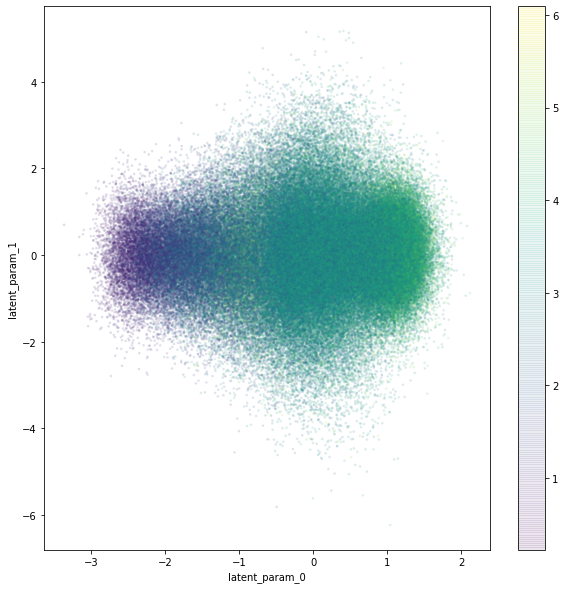

In [35]:
figsize = 10


z_points = conv_vae.encoder.predict(df.to_numpy().reshape(-1,L,L,2))

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize=(figsize, figsize))
#plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)
plt.scatter(z_points[:, 0] , z_points[:, 1], c=df_conf['M'], alpha=0.1, s=3)
plt.xlabel("latent_param_0")
plt.ylabel("latent_param_1")
plt.colorbar()
plt.show()



In [96]:
df.shape

(20000, 512)

In [97]:
df_conf.shape

(20000, 258)

In [36]:
df2 = df.copy()
df2['M'] = df_conf['M'].to_numpy()

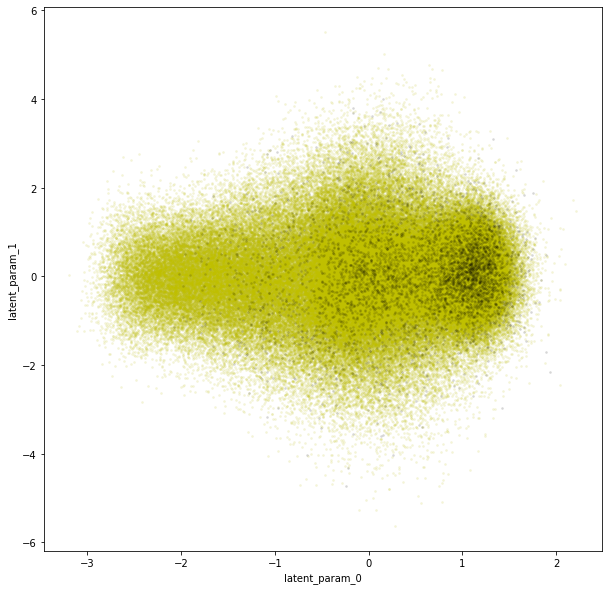

In [50]:
figsize = 10


z_points = conv_vae.encoder.predict(df.to_numpy().reshape(-1,L,L,2))

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize=(figsize, figsize))
#plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)
#plt.scatter(z_points[:, 0] , z_points[:, 1], c=df_conf['T'], alpha=0.1, s=3)
plt.scatter(z_points[:, 0] , z_points[:, 1], c='y', alpha=0.1, s=3)
plt.xlabel("latent_param_0")
plt.ylabel("latent_param_1")



figsize = 10

#filtered_df = df2[df2['M'] < 1.0].drop(["M"], axis=1)
#filtered_df = df2[(df2['M'] > 1.5) & (df2['M'] < 2.0)].drop(["M"], axis=1)
#filtered_df = df2[(df2['M'] > 2.5) & (df2['M'] < 2.8)].drop(["M"], axis=1)
#filtered_df = df2[(df2['M'] > 3.5) & (df2['M'] < 3.6)].drop(["M"], axis=1)
#filtered_df = df2[(df2['M'] > 3.6) & (df2['M'] < 3.7)].drop(["M"], axis=1)
#filtered_df = df2[(df2['M'] > 3.7) & (df2['M'] < 3.8)].drop(["M"], axis=1)
#filtered_df = df2[(df2['M'] > 3.8) & (df2['M'] < 3.9)].drop(["M"], axis=1)
filtered_df = df2[(df2['M'] > 3.9) & (df2['M'] < 4.0)].drop(["M"], axis=1)
#filtered_df = df2[df2['M'] > 5.0].drop(["M"], axis=1)

z_points_2 = conv_vae.encoder.predict(filtered_df.to_numpy().reshape(-1,L,L,2))

min_x = min(z_points_2[:, 0])
max_x = max(z_points_2[:, 0])
min_y = min(z_points_2[:, 1])
max_y = max(z_points_2[:, 1])

#plt.scatter(z_points_2[:, 0] , z_points_2[:, 1], c='black', alpha=0.5, s=2)
plt.scatter(z_points_2[:, 0] , z_points_2[:, 1], c='k',alpha=0.1, s=3)
plt.xlabel("latent_param_0")
plt.ylabel("latent_param_1")
plt.show()



In [66]:
df.drop(index=df_conf[df_conf['M'] > 0.0].index)
df.drop(index=df_conf[df_conf['M'] > 0.0].index)

0                   1                  10                 100  \
               x         y         x         y         x         y         x   
10000   0.817268  0.576257  0.233436  0.972372  0.404670  0.914463  0.199034   
10001  -0.943087  0.332545 -0.897286  0.441450 -0.999415 -0.034203 -1.000000   
10002   0.974038 -0.226385  0.928794  0.370597  0.999315  0.037019  0.998393   
10003  -0.244251  0.969712 -0.570311  0.821429 -0.440449  0.897778 -0.648432   
10004  -0.701040  0.713122 -0.811418  0.584467 -0.859918  0.510433 -0.914911   
...          ...       ...       ...       ...       ...       ...       ...   
199995  0.972849 -0.231441  0.094902  0.995487  0.995847  0.091043  0.866387   
199996  0.767148 -0.641470  0.935878  0.352324  0.734895  0.678181  0.112359   
199997  0.355182  0.934797  0.863640  0.504108  0.541334  0.840808 -0.274097   
199998 -0.837963 -0.545728 -0.910551  0.413397 -0.247912 -0.968783 -0.219128   
199999  0.968190 -0.250216 -0.767375  0.641199  0.062650  0.998036  0.963963   

                       101            ...        95                  96  \
               y         x         y  ...         x         y         x   
10000   0.979993  0.574416  0.818564  ...  0.773585  0.633693  0.576710   
10001   0.000228 -0.968486  0.249067  ... -0.999129 -0.041728 -0.998835   
10002  -0.056674  0.887762  0.460303  ...  0.984979 -0.172677  0.998669   
10003   0.761273 -0.709483  0.704723  ...  0.034322  0.999411  0.027139   
10004   0.403655 -0.996254  0.086471  ... -0.255146  0.966903 -0.486157   
...          ...       ...       ...  ...       ...       ...       ...   
199995 -0.499374  0.895477 -0.445107  ...  0.163646  0.986519  0.820065   
199996 -0.993668  0.164847  0.986319  ... -0.791902  0.610649 -0.706129   
199997 -0.961702 -0.473178 -0.880967  ...  0.532440 -0.846468  0.981438   
199998 -0.975696 -0.672153 -0.740412  ...  0.991617 -0.129213  0.570984   
199999 -0.266036  0.712408 -0.701765  ... -0.996632 -0.082003  0.876971   

                        97                  98                  99            
               y         x         y         x         y         x         y  
10000   0.816949  0.799772  0.600304  0.743826  0.668374  0.395645  0.918403  
10001   0.048263 -0.996688  0.081321 -0.999205 -0.039855 -0.996269  0.086302  
10002  -0.051582  0.982079 -0.188470  0.997630 -0.068807  0.997037 -0.076930  
10003   0.999632  0.320180  0.947357 -0.118127  0.992998  0.079989  0.996796  
10004   0.873871 -0.534031  0.845465 -0.652048  0.758178 -0.784970  0.619534  
...          ...       ...       ...       ...       ...       ...       ...  
199995  0.572270 -0.148309 -0.988941 -0.244211  0.969722 -0.786918 -0.617057  
199996 -0.708083 -0.961756  0.273906 -0.986207  0.165514 -0.932619  0.360862  
199997 -0.191778  0.828419 -0.560109  0.733478  0.679713  0.916775  0.399403  
199998 -0.820961  0.996787  0.080096  0.369739 -0.929136  0.269070 -0.963121  
199999 -0.480544 -0.928166 -0.372166 -0.995146  0.098413  0.301626 -0.953426  

[190000 rows x 512 columns]

In [64]:
df_conf[df_conf['M'] > 6].index

Int64Index([ 757, 1159, 1991, 3485, 3579, 4153, 4426, 4630, 4880, 5203, 5571,
            5597, 5634, 7360, 8124, 8606, 8878, 9303, 3214, 3844, 4219],
           dtype='int64')

In [62]:
df_conf.head()
#test_with_meta_info = df_conf.drop(index=train_with_meta_info.index)

,0,1,2,3,4,5,6,7,8,9,...,248,249,250,251,252,253,254,255,T,M
0,1.556908,1.700251,1.286740,1.333554,1.935889,1.392411,1.903922,1.781047,1.644003,1.456510,...,1.724801,1.794323,2.160901,2.016668,1.862466,2.099976,1.755041,2.080891,0.1,1.676787
1,0.449358,0.284169,0.110582,0.316963,0.309245,0.007220,0.132248,0.248091,6.199557,6.210290,...,0.113690,0.187911,0.381211,0.439792,0.533806,0.380159,6.243337,0.342518,0.1,0.998589
2,5.874689,5.861319,5.717695,5.349464,5.149222,5.051441,5.754105,5.572867,5.614452,5.757395,...,5.947179,5.673022,5.783555,5.720445,5.787259,5.683092,5.809804,5.735588,0.1,5.631094
3,0.579087,0.398948,0.059830,0.212079,0.207130,0.406396,0.264235,0.255291,0.622365,0.351162,...,0.847066,0.497288,0.783738,0.665467,0.731709,0.514824,0.226228,0.894068,0.1,0.421956
4,3.180521,3.118362,3.202986,3.077825,2.982245,3.182920,2.962104,2.911524,2.588305,2.857718,...,2.919455,3.058893,3.098180,2.882240,2.939362,3.138479,3.188607,3.699828,0.1,3.030602


In [ ]:
df.index()

<AxesSubplot:>

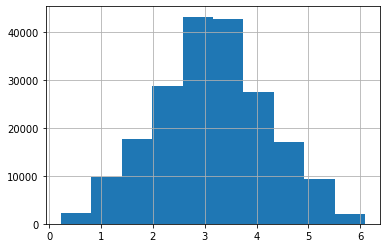

In [49]:
df_conf['M'].hist()

In [100]:
#df_conf#.filter(items=test.index,axis=1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,T,M
0,0.162246,5.973095,6.133531,6.156717,0.025063,6.050038,6.020508,6.223365,0.067779,6.153401,6.032560,0.073008,6.134114,6.160847,0.052111,0.115091,0.1,4.606397
1,4.983357,4.822849,4.691446,4.885390,5.122919,4.853683,4.793827,4.921220,4.869675,5.132625,5.236716,4.908288,4.935758,4.859949,4.700985,5.001698,0.1,4.845760
2,2.727240,2.390374,2.708473,2.618912,2.354293,2.384652,2.535973,2.779869,2.592872,2.413333,2.715683,2.716086,2.763101,2.847251,2.660584,2.721994,0.1,2.611250
3,5.762936,5.839879,0.023180,6.216394,6.118754,6.144861,0.033664,0.032085,6.282960,0.085963,0.031738,0.152408,6.027732,6.234099,0.083261,0.023046,0.1,4.460597
4,4.463147,4.564015,4.342138,4.595675,4.269949,4.323170,4.407668,4.411044,4.368104,4.413393,4.490482,4.530060,4.503687,4.435605,4.239925,4.452277,0.1,4.491244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.961475,1.120173,3.015277,2.859901,2.462753,2.679678,2.562129,2.602867,2.938824,3.958659,4.160392,2.777843,2.834264,4.521152,2.697978,1.350121,2.0,2.239206
9996,0.927484,2.693284,4.823525,1.834211,6.002589,5.645381,3.207167,4.518647,5.060423,5.677578,0.403435,5.751913,1.318353,2.530393,4.150466,1.381927,2.0,2.569626
9997,3.083439,1.528634,0.451843,0.193794,3.808864,0.592086,0.642117,0.565445,1.159416,0.645269,0.918636,5.468957,5.592771,4.934163,2.095211,5.710414,2.0,1.314428
9998,0.596467,2.204761,2.766275,0.787203,5.765027,0.611504,2.502742,2.034828,3.014334,1.091611,2.908084,2.321281,2.603204,0.203233,6.219547,1.086780,2.0,1.588676


# No XY Transform Convolutional VAE

In [154]:
np_angle_matrix 

array([[1.55690843, 1.70025141, 1.28674023, ..., 2.09997621, 1.75504112,
        2.08089115],
       [0.44935849, 0.28416884, 0.11058151, ..., 0.38015945, 6.2433374 ,
        0.34251793],
       [5.87468896, 5.8613193 , 5.71769467, ..., 5.68309194, 5.80980446,
        5.73558826],
       ...,
       [1.20768768, 0.52834934, 0.99877405, ..., 5.68866769, 0.74737111,
        0.41086593],
       [3.71884998, 2.71541102, 4.46186487, ..., 0.08018239, 5.09111687,
        4.98481653],
       [6.03028175, 2.44553304, 1.50810501, ..., 3.52293472, 3.04302033,
        5.01878671]])

In [ ]:
no_transform_train = df_conf.drop(["T","M"], axis=1).to_numpy()

In [157]:
train_with_meta_info = df_conf.sample(frac=TRAINING_FRACTION, axis=0)
test_with_meta_info = df_conf.drop(index=train_with_meta_info.index)
train = train_with_meta_info.drop(["T","M"], axis=1)
test = test_with_meta_info.drop(["T","M"], axis=1)

x = train.to_numpy().reshape(-1,L,L,1)
x_test = test.to_numpy().reshape(-1,L,L,1)

In [159]:
conv_vae_2 = VariationalAutoencoder(
    input_dim = (L,L,1)
    , encoder_conv_filters = [8,8,16]
    , encoder_conv_kernel_size = [3,3,3]
    , encoder_conv_strides = [1,2,1]
    , decoder_conv_t_filters = [16,8,1]
    , decoder_conv_t_kernel_size = [3,3,3]
    , decoder_conv_t_strides = [1,2,1]
    , z_dim = 2
)

In [160]:
CONV_2_BATCH_SIZE = 16
CONV_2_EPOCHS = 5
CONV_2_PRINT_EVERY_N_BATCHES = 100
CONV_2_INITIAL_EPOCH = 0

In [162]:
CONV_2_LEARNING_RATE = 0.0005
CONV_2_R_LOSS_FACTOR = 1000

In [165]:
conv_vae_2.compile(CONV_2_LEARNING_RATE, CONV_2_R_LOSS_FACTOR)

In [166]:
conv_vae_2.train(     
    x
    , batch_size = CONV_2_BATCH_SIZE
    , epochs = CONV_2_EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = CONV_2_PRINT_EVERY_N_BATCHES
    , initial_epoch = CONV_2_INITIAL_EPOCH
)

Train on 160000 samples
Epoch 1/5
   864/160000 [..............................] - ETA: 1:15 - loss: 9622.8351 - vae_r_loss: 9479.7900 - vae_kl_loss: 143.0446

2022-09-09 09:00:29.848615: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-09-09 09:00:29.848630: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-09-09 09:00:29.851905: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-09-09 09:00:29.852638: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-09-09 09:00:29.853580: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /home/owen/logs/fit/20220909-090028/plugins/profile/2022_09_09_09_00_29

2022-09-09 09:00:29.854140: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /home/owen/logs/fit/20220909-090028/plugins/profile/2022_09_09_09_00_29/owen-PRIME-Z390-A.trace.json.gz
2022-09-09 09:00:29.855303: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /home/owen/logs/fit/202

159744/160000 [============================>.] - ETA: 0s - loss: 7889.8683 - vae_r_loss: 7887.8159 - vae_kl_loss: 2.0596
Epoch 1: saving model to /home/owen/repos/z3support/notebooks/run/vae/0003_xy/weights/weights-001-7889.27.h5

Epoch 1: saving model to /home/owen/repos/z3support/notebooks/run/vae/0003_xy/weights/weights.h5
160000/160000 [==============================] - 29s 181us/sample - loss: 7889.2704 - vae_r_loss: 7887.2192 - vae_kl_loss: 2.0563 - lr: 5.0000e-04
Epoch 2/5
159792/160000 [============================>.] - ETA: 0s - loss: 7877.7004 - vae_r_loss: 7877.6899 - vae_kl_loss: 1.9683e-04
Epoch 2: saving model to /home/owen/repos/z3support/notebooks/run/vae/0003_xy/weights/weights-002-7877.99.h5

Epoch 2: saving model to /home/owen/repos/z3support/notebooks/run/vae/0003_xy/weights/weights.h5
160000/160000 [==============================] - 28s 176us/sample - loss: 7877.9866 - vae_r_loss: 7877.9761 - vae_kl_loss: 1.9661e-04 - lr: 5.0000e-04
Epoch 3/5
159888/160000 [=======

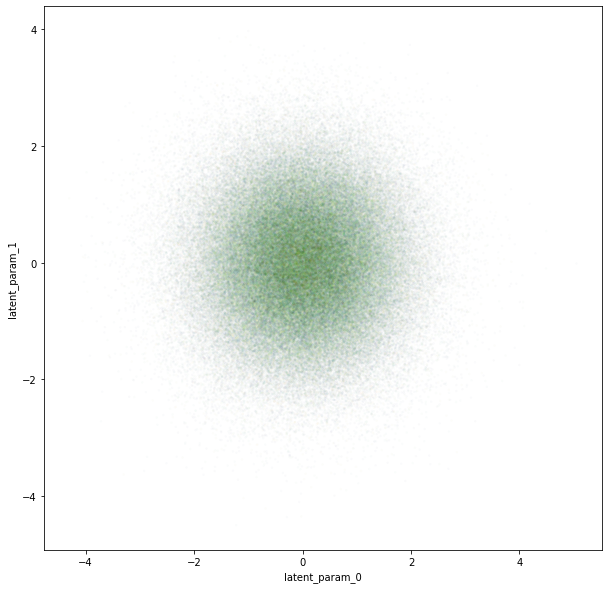

In [171]:
figsize = 10

z_points = conv_vae_2.encoder.predict(df_conf.drop(["T","M"], axis=1).to_numpy().reshape(-1,L,L,1))

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize=(figsize, figsize))
#plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)
plt.scatter(z_points[:, 0] , z_points[:, 1], c=df_conf['T'], alpha=0.01, s=3)
plt.xlabel("latent_param_0")
plt.ylabel("latent_param_1")
plt.show()

